In [1]:
# Initial Setup

train=True
Epochs=30
preload=False
hough=False
rams=False
dynAug=False
depth = 6
chan = 64
ir = 1.1
rand_sv = 42
ds = 'MIX'
zone = 'CUP'
cup = True
mix = True
dri = False
rim = False

In [2]:
# Import all the necessary libraries

import tensorflow as tf
import os
import glob
from datetime import datetime
import warnings
warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import skimage.transform
import skimage.measure
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, Lambda, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import math
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter, ellipse
from skimage.measure import  ransac, EllipseModel

In [3]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)
def log_dice_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

# Computes mean Intersection-over-Union (IOU) for two arrays of binary images.

def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [4]:
# helper function to increase the brightness
# hue, saturation, value

def modify_brightness_p(img, p=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 1.0/p
    v[v > lim] = 1.0
    v[v <= lim] *= p

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR).clip(min=0)
    return img

In [5]:
def index512_resize(index,top):
    index=index*top/512
    return int(index)

In [6]:
# helper code to shuffle instead of random shuffle 

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [7]:
K.set_floatx('float32')

In [8]:
#load the data

h5f2 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), r'C:\Users\Ranjith ch\Desktop\code\glucoma\model\data', 'DRISHTI_GS.hdf5'), 'r')

In [9]:
from keras.regularizers import l2
smooth = 1.
dropout_rate = 0.5
act = "relu"

In [10]:
def wU_Net(img_rows=256, img_cols=256):
    inputs = Input(( img_rows, img_cols,3))
    conv1 = Conv2D(35, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(35, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(70, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(70, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(140, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(140, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(280, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(280, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(560, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(560, kernel_size=3, activation='relu', padding='same')(conv5)
#####
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis = -1)
    conv6 = Conv2D(280, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(280, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(140, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(140, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis = -1)
    conv8 = Conv2D(70, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(70, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis = -1)
    conv9 = Conv2D(35, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [11]:
# DRISHTI Dataset
# step1: prepare the data for our model injection

Xori= np.asarray(h5f2['DRISHTI-GS/orig/images'])
disc_locations = np.asarray( h5f2['DRISHTI-GS/512 px/disc_locations'])
FC = np.asarray(h5f2['DRISHTI-GS/512 px/file_codes'] ) 
indDRI = np.arange(0,Xori.shape[0])
bsqside=np.maximum((disc_locations[:,3]-disc_locations[:,1]),(disc_locations[:,2]-disc_locations[:,0]))
isize=Xori.shape[1]

if (cup):
  
  Yf = np.asarray(h5f2['DRISHTI-GS/512 px/cup'])
 
  Xc = [Xori[i][index512_resize(disc_locations[i][0],isize):index512_resize(disc_locations[i][0]+bsqside[i],isize), index512_resize(disc_locations[i][1],isize):index512_resize(disc_locations[i][1]+bsqside[i],isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][disc_locations[i][0]:disc_locations[i][0]+bsqside[i], disc_locations[i][1]:disc_locations[i][1]+bsqside[i]] 
                   for i in range(len(Xori))]

else:
  Yf =np.asarray( h5f2['DRISHTI-GS/512 px/disc'])
  
  Xc = [Xori[i][index512_resize(50,isize):index512_resize(462,isize), index512_resize(50,isize):index512_resize(462,isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][50:462,50:462] 
                   for i in range(len(Xori))]

X=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xc]
X=np.asarray(X) 
am=np.amax(X)
X=X.astype(np.float32)/am 
print(np.amax(X),np.amin(X))

Y=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yc]
Y=np.asarray(Y) 
ym=np.amax(Y) 
Yf=Y/ym
#get binary mask
Yb=(Y>0.5).astype(np.float32) 

print(np.amax(Yf),np.amin(Yf))
print(X.shape)

1.0 0.0
1.0 0.0
(50, 128, 128, 3)


In [12]:
# step2: Create train and test set by combining datasets

rng = np.random.RandomState(rand_sv)

#DRISHTI
X_train1t, X_test1t, Y_train1t, Y_test1t, F_train1t, F_test1t ,ind_train1, ind_test1= train_test_split( X, Yb, FC, indDRI,test_size=0.25,random_state=rng)

X_test_dri=np.copy(X_test1t)
Y_test_dri=np.copy(Y_test1t)
F_test_dri=np.copy(F_test1t)


if(dri or mix):
  X_train1=np.concatenate([X_train1t,X_train1t])
  X_train1=np.concatenate([X_train1,X_train1t])
  X_test1=np.concatenate([X_test1t,X_test1t])
  X_test1=np.concatenate([X_test1,X_test1t])

  Y_train1=np.concatenate([Y_train1t,Y_train1t])
  Y_train1=np.concatenate([Y_train1,Y_train1t])
  Y_test1=np.concatenate([Y_test1t,Y_test1t])
  Y_test1=np.concatenate([Y_test1,Y_test1t])


if(dri):
  X_train1=np.concatenate([X_train1,X_train1])
  Y_train1=np.concatenate([Y_train1,Y_train1])

X_train1=np.asarray(X_train1)
Y_train1=np.asarray(Y_train1)
X_test=np.asarray(X_test1)
Y_test=np.asarray(Y_test1)

X_train=np.copy(X_train1)
Y_train=np.copy(Y_train1)

size=X_train1.shape[0]

X_traine=np.empty((20*size, 128, 128, 3),dtype=np.float32)
Y_traine=np.empty((20*size, 128, 128, 1),dtype=np.float32) 

In [13]:
# Step3: Preprocessing step for Cup Segmentation
# Perform CLAHE on each image

for i in range(16):
  X_traine[i*size:(i+1)*size]=X_train1
  Y_traine[i*size:(i+1)*size]=Y_train1
  
base= 16*size

for j in tqdm_notebook(range(X_train1.shape[0])):
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.04)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.02)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],0.9)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],1.1)
  Y_traine[base]=Y_train1[j]
  base+=1
  
X_testc=np.copy(X_test)
Y_testc=np.copy(Y_test)

sizev=X_testc.shape[0]

X_teste=np.empty((20*sizev, 128, 128, 3),dtype=np.float32)
Y_teste=np.empty((20*sizev, 128, 128, 1),dtype=np.float32)

for i in range(8):
  X_teste[i*sizev:(i+1)*sizev]=X_testc
  Y_teste[i*sizev:(i+1)*sizev]=Y_testc
  
basev= 8*sizev

for j in tqdm_notebook(range(X_testc.shape[0])):
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.04)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.02)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],0.9)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],1.1)
  Y_teste[basev]=Y_testc[j]
  basev+=1

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [14]:
# step4: Shuffle the dataset

X_trains,Y_trains = unison_shuffled_copies(X_traine, Y_traine)
X_tests,Y_tests = unison_shuffled_copies(X_teste, Y_teste)

In [15]:

seed = rand_sv
batch_s = 120

In [16]:
# helper function for ipython notebook

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\wuent_last_check_point.hdf5'), verbose=1, save_best_only=True,save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=2e-4)

In [17]:
img_shape = (128,128,3)

In [18]:
img_shape

(128, 128, 3)

In [19]:
model = wU_Net(img_rows=128, img_cols=128)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.001, ),
    loss=log_dice_loss, metrics=[dice_coef]
    )

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 35  980         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 35  0           ['conv2d[0][0]']                 
                                )                                                             

In [22]:
# Model Training Step 

if(train):
  history = model.fit(
    X_trains,Y_trains,
    epochs=20,
    batch_size=128,
    steps_per_epoch=35,
    validation_data = (X_tests,Y_tests),
    callbacks=[cp_callbacks,reduce_lr],
    verbose=1
  )

# save the trained model weights
model.save_weights(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\wunet_cup_last_check_point.hdf5'), overwrite=True)

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.8930 - dice_coef: 0.4093 
Epoch 00001: val_loss improved from inf to 1.24082, saving model to C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\wuent_last_check_point.hdf5
35/35 [==============================] - 890s 25s/step - loss: 0.8930 - dice_coef: 0.4093 - val_loss: 1.2408 - val_dice_coef: 0.2945 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.8914 - dice_coef: 0.4101 
Epoch 00002: val_loss did not improve from 1.24082
35/35 [==============================] - 867s 25s/step - loss: 0.8914 - dice_coef: 0.4101 - val_loss: 1.2408 - val_dice_coef: 0.2945 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.8896 - dice_coef: 0.4112 
Epoch 00003: val_loss did not improve from 1.24082
35/35 [==============================] - 859s 25s/step - loss: 0.8896 - dice_coef: 0.4112 - val_loss: 1.2408 - val_dice_coef: 0.2945 - lr: 0.0010
Epoch 4/20
35/35 [=============

In [23]:
result = model.evaluate(X_tests[0:700,:,:,:],Y_tests[0:700,:,:,:])
print("log dice loss for test set = ", result[0], ' ||| ',"dice coeffecient (accuracy) for test set = ", result[1])

22/22 [==============================] - 30s 1s/step - loss: 1.2542 - dice_coef: 0.2871
log dice loss for test set =  1.2542309761047363  |||  dice coeffecient (accuracy) for test set =  0.2870672643184662


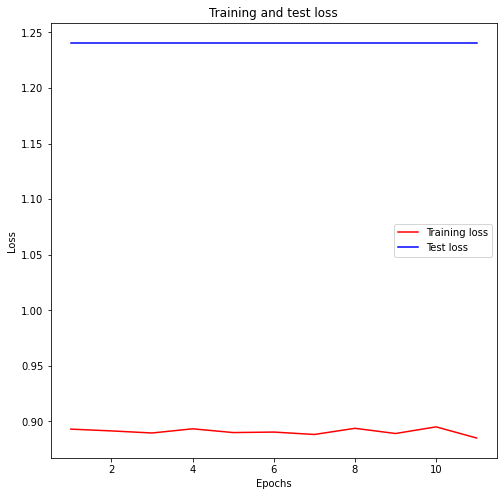

In [24]:

if(train):
  loss = history.history['loss']
  val_loss=history.history['val_loss']
  acc=history.history['dice_coef']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Test loss')
  plt.title('Training and test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plt.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','loss'+'model1_cup'+'.png'),dpi=600)

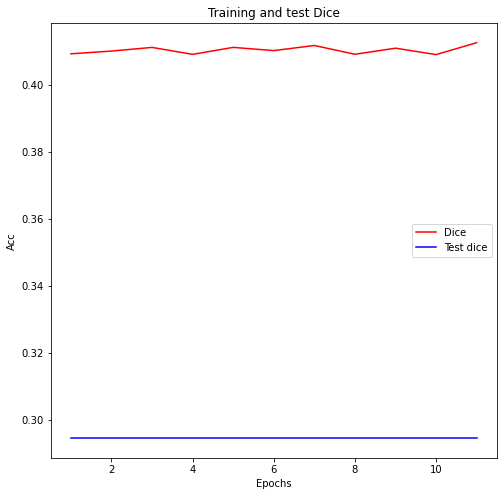

In [25]:
# plot train and test dice coeffecient (accuracy)
if(train):
  loss = history.history['loss']
  acc=history.history['dice_coef']
  val_acc=history.history['val_dice_coef']
  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, acc, 'r', label='Dice')
  plt.plot(epochs, val_acc, 'b', label='Test dice')
  plt.title('Training and test Dice')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()
  #plt.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','hist'+'model1_cup'+'.png'),dpi=600)

In [26]:
# Defining metrics again

smooth=1e-07
def np_dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )
    
def np_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( ( intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth) )   

In [27]:
test_s=int(X_test_dri.shape[0])
test_s

13

In [28]:
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

Dice mean= 0.43636197  Std= 0.07688285  best= 0.512101  worst= 0.27109164
IOU mean= 0.28202936  Std= 0.0602827  best= 0.34417725  worst= 0.15679932
image #1
0.512101
image #7
0.27109164


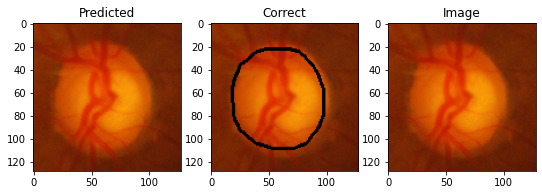

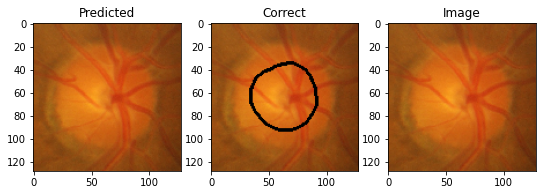

In [29]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    #fig.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','img_drishti'+str(j)+'model1_cup'+'.png'),dpi=600)
    j+=1

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

image #0
0.43969336


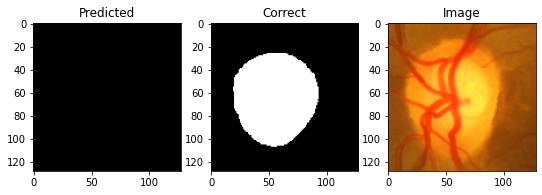

image #1
0.512101


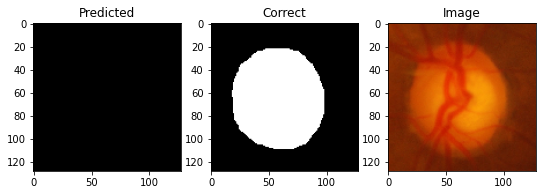

image #2
0.5003204


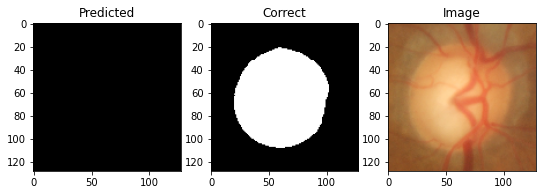

image #3
0.29128644


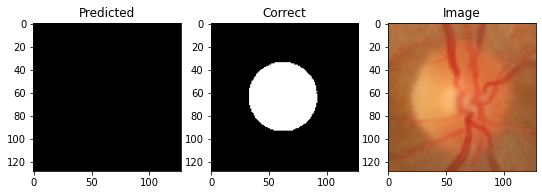

image #4
0.43357712


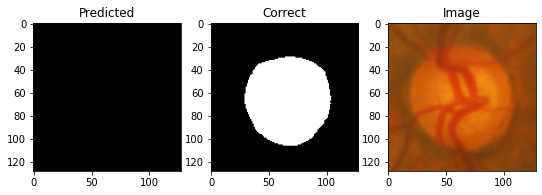

image #5
0.40226242


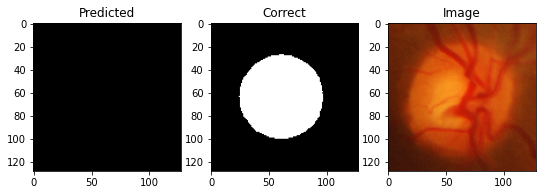

image #6
0.50606364


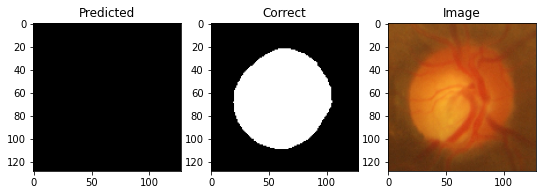

image #7
0.27109164


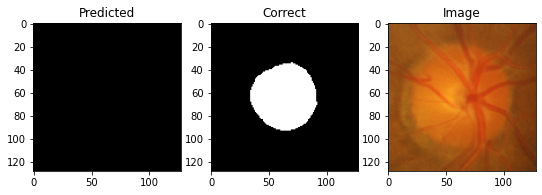

image #8
0.42005786


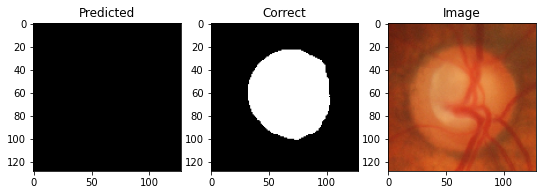

image #9
0.51149267


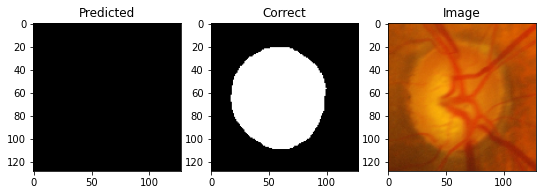

image #10
0.40506205


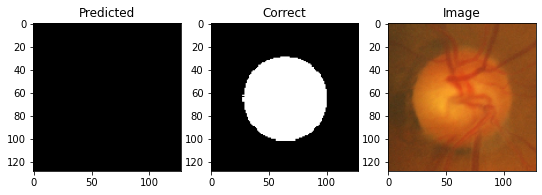

image #11
0.4887003


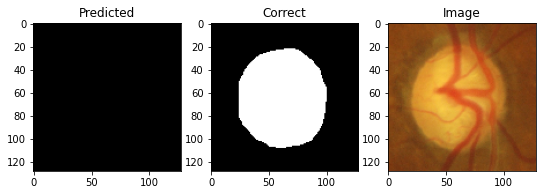

image #12
0.49099702


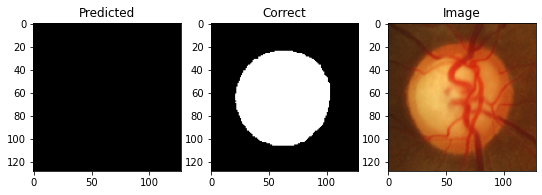

In [30]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    

j=0
for i in range(test_s):
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    plt.show()
    j+=1

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

Dice mean= 0.43636197  Std= 0.07688285  best= 0.512101  worst= 0.27109164
IOU mean= 0.28202936  Std= 0.0602827  best= 0.34417725  worst= 0.15679932
image #0
0.43969336
image #1
0.512101
image #2
0.5003204
image #3
0.29128644
image #4
0.43357712
image #5
0.40226242
image #6
0.50606364
image #7
0.27109164
image #8
0.42005786
image #9
0.51149267
image #10
0.40506205
image #11
0.4887003
image #12
0.49099702


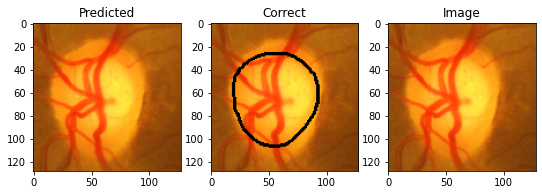

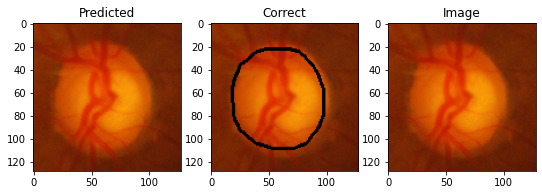

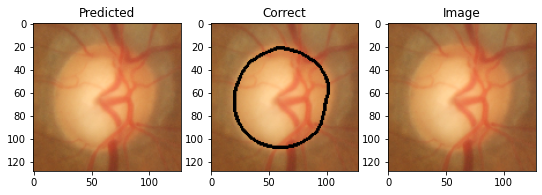

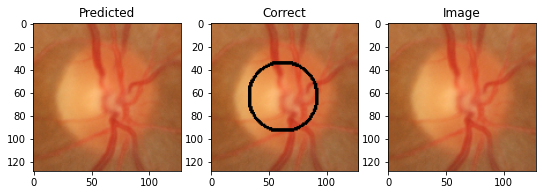

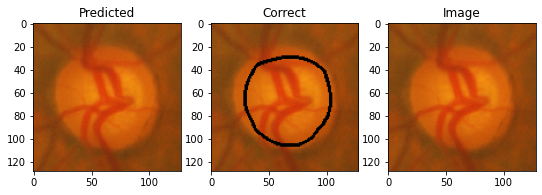

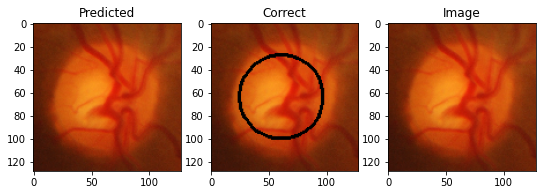

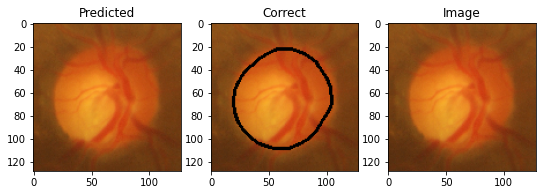

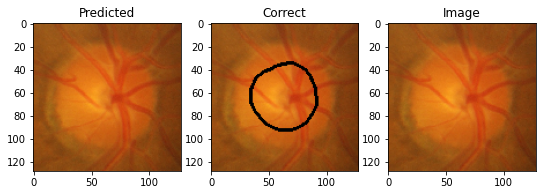

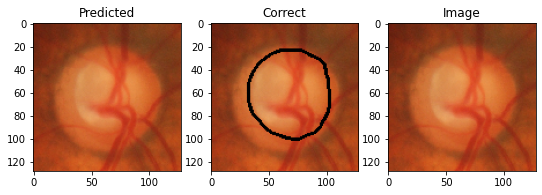

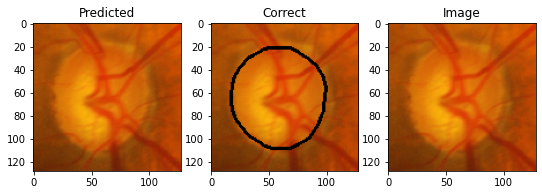

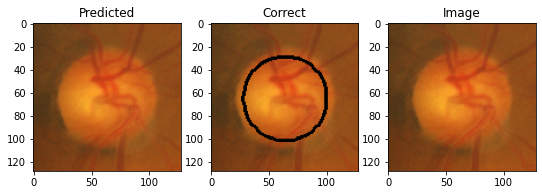

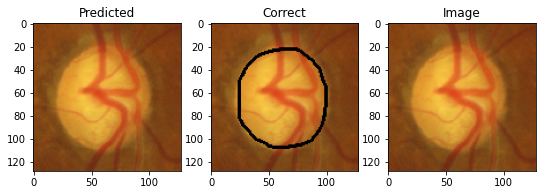

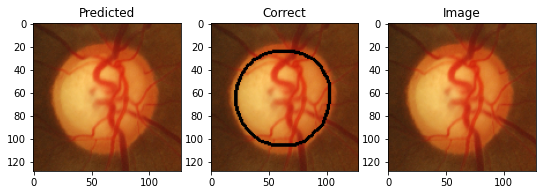

In [31]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in range(test_s):
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    #fig.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','img_drishti'+str(j)+'model1_cup'+'.png'),dpi=600)
    j+=1